# 1. Imports 

In [20]:
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'

# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()


# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_v3.csv')

# 2. Data

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)
x_obs = x_scaler.transform(X_obs.values)



c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [22]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[1]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# 3. NN Training

In [23]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

#normalize = layers.Normalization()

# This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
# It accomplishes this by precomputing the mean and variance of the data and calling (input - mean) / sqrt(var) at runtime

# TODO: Probar con los datos sin normalizar
#normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  #normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [24]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 701, 1)]          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 701, 32)           128       
                                                                 
 conv1d_10 (Conv1D)          (None, 701, 32)           3104      
                                                                 
 conv1d_11 (Conv1D)          (None, 701, 32)           3104      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 234, 32)          0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 234, 64)           4160      
                                                           

In [25]:
model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=30)

Epoch 1/30
459/459 [==============================] - 77s 166ms/step - loss: 0.0601 - MAE: 0.1925 - val_loss: 0.0284 - val_MAE: 0.1260
Epoch 2/30
459/459 [==============================] - 6s 13ms/step - loss: 0.0162 - MAE: 0.0923 - val_loss: 0.0147 - val_MAE: 0.0928
Epoch 3/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0088 - MAE: 0.0668 - val_loss: 0.0068 - val_MAE: 0.0585
Epoch 4/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0053 - MAE: 0.0511 - val_loss: 0.0033 - val_MAE: 0.0371
Epoch 5/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0031 - MAE: 0.0402 - val_loss: 0.0025 - val_MAE: 0.0373
Epoch 6/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0024 - MAE: 0.0354 - val_loss: 0.0020 - val_MAE: 0.0356
Epoch 7/30
459/459 [==============================] - 6s 12ms/step - loss: 0.0016 - MAE: 0.0289 - val_loss: 0.0010 - val_MAE: 0.0226
Epoch 8/30
459/459 [==============================] - 6s 12ms/step 

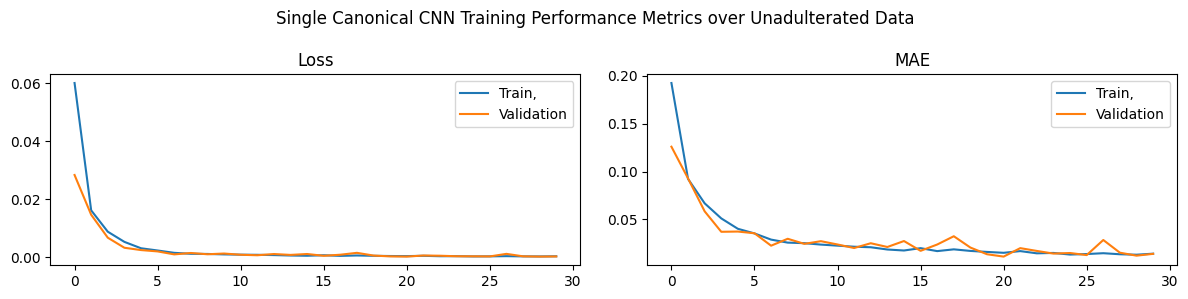

In [26]:
fig, axis = plt.subplots(1, 2, figsize=(12,3))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')

# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.suptitle('Single Canonical CNN Training Performance Metrics over Unadulterated Data')
plt.tight_layout()
plt.show()

In [27]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(x_val, y_val)

print('loss: %.4f  MAE:%.4f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 4ms/step - loss: 3.0960e-04 - MAE: 0.0140
loss: 0.0003  MAE:0.0140


In [28]:
predictions = model.predict(x_test)

153/153 [==============================] - 1s 3ms/step


In [29]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.4f  MAE:%.4f'% (losses[0],maes[0]))
print('log g -       loss: %.4f  MAE:%.4f'% (losses[1],maes[1]))
print('v -           loss: %.4f  MAE:%.4f'% (losses[2],maes[2]))


Temperatura - loss: 0.0004  MAE:0.0160
log g -       loss: 0.0003  MAE:0.0136
v -           loss: 0.0002  MAE:0.0123


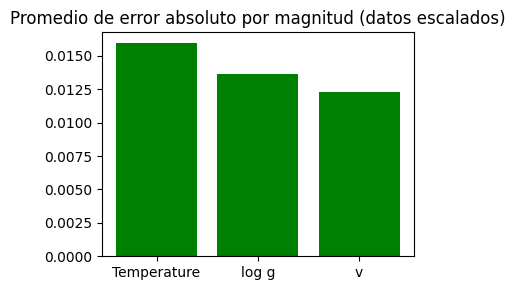

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(predictions-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [31]:
predictions = y_scaler.inverse_transform(predictions)

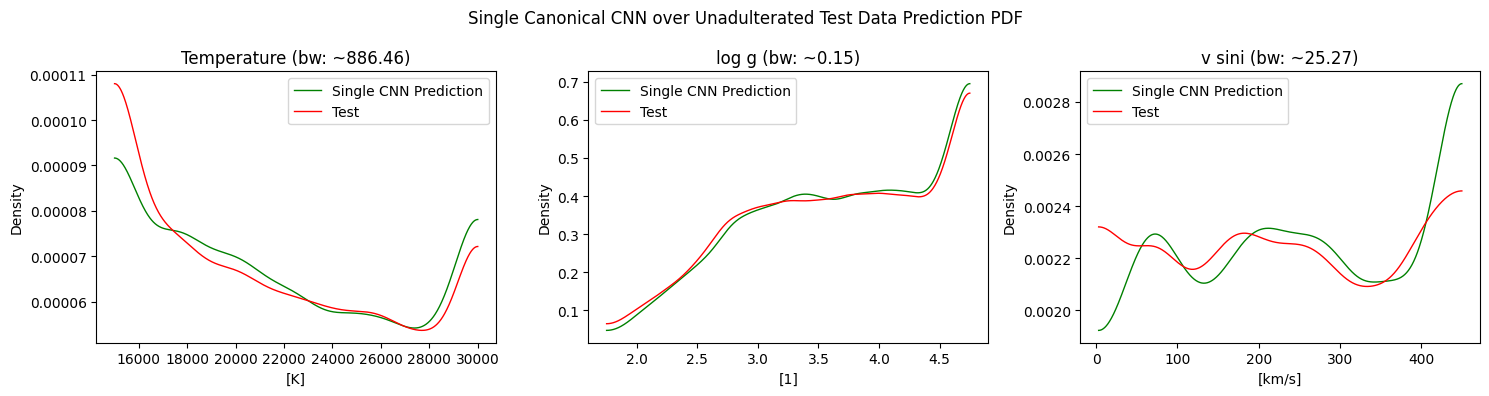

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Single CNN Prediction')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Density')
	axes[i].set_title(measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.suptitle('Single Canonical CNN over Unadulterated Test Data Prediction PDF')
plt.legend()
plt.tight_layout();
plt.show()

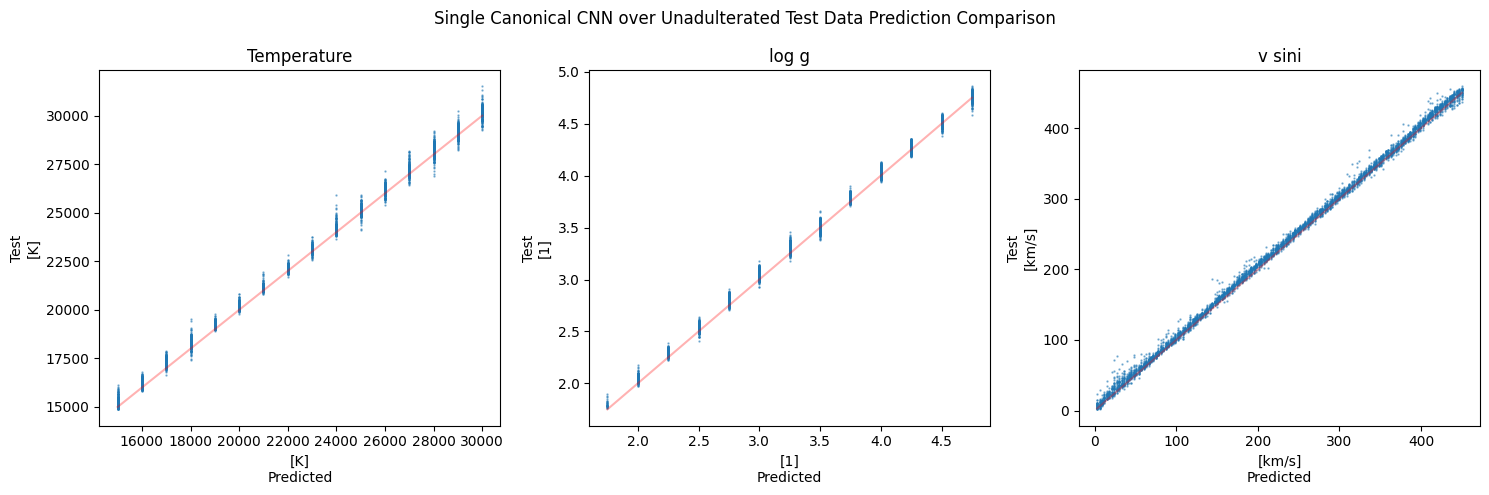

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Canonical CNN over Unadulterated Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

## Resultados datos de testing

In [34]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [35]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(20)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17182,182 (1.1%),3.25,3.29,0.04 (1.4%),246,255,9 (3.8%)
1,18000,18156,156 (0.9%),2.75,2.76,0.01 (0.4%),285,291,6 (2.1%)
2,30000,30439,439 (1.5%),3.75,3.79,0.04 (1.1%),267,274,7 (2.7%)
3,23000,23474,474 (2.1%),2.5,2.57,0.07 (2.9%),63,67,4 (6.6%)
4,19000,19328,328 (1.7%),3.0,3.03,0.03 (1.1%),126,136,10 (7.6%)
5,17000,17353,353 (2.1%),4.5,4.5,0.0 (0.1%),156,157,1 (0.9%)
6,28000,28458,458 (1.6%),3.25,3.38,0.13 (4.1%),450,448,2 (0.5%)
7,22000,22105,105 (0.5%),4.0,4.03,0.03 (0.9%),285,293,8 (3.0%)
8,23000,23344,344 (1.5%),3.0,3.07,0.07 (2.4%),30,36,6 (19.9%)
9,23000,22986,14 (0.1%),4.5,4.51,0.01 (0.2%),153,161,8 (5.3%)


## Datos Observados

In [36]:
predictions = model.predict(x_obs)

5/8 [=================>............] - ETA: 0s

8/8 [==============================] - 0s 13ms/step


In [37]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 13.489  MAE:2.696
log g -       loss: 12.838  MAE:2.536
v -           loss: 1.450  MAE:0.985


In [38]:
predictions = y_scaler.inverse_transform(predictions)

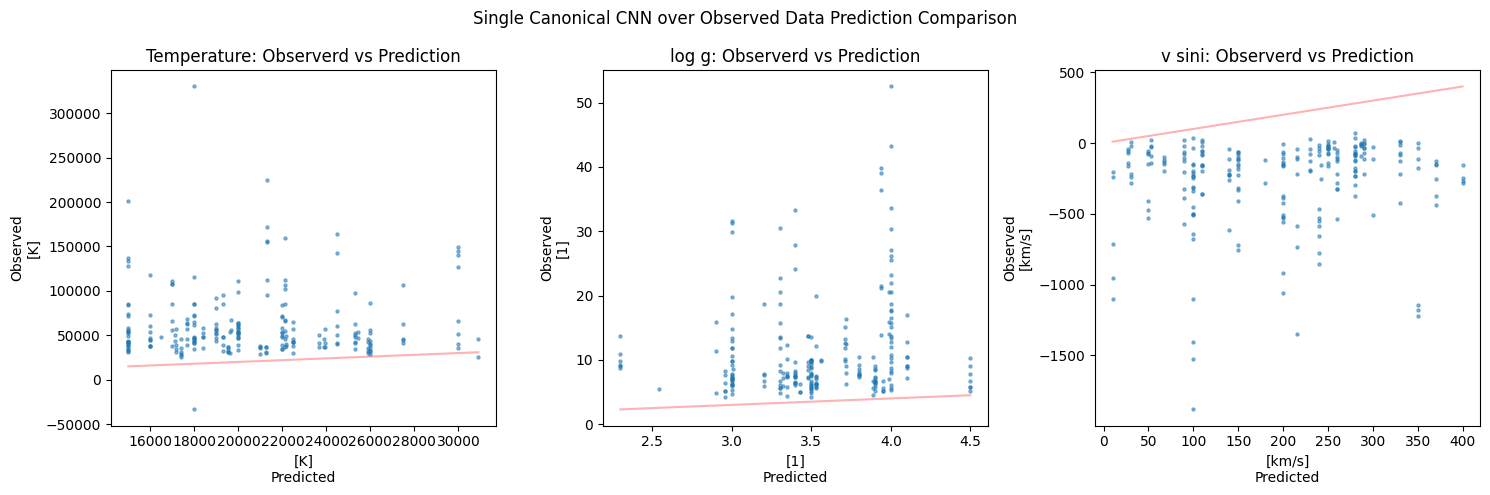

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Observerd vs Prediction')
 
plt.suptitle('Single Canonical CNN over Observed Data Prediction Comparison')
plt.tight_layout();
plt.show()

In [40]:
# xi
def xi(obs,sint):
  return np.sum((obs - sint)**2/sint)
def get_closest_spectra_line(index):
  obs = x_obs[index]
  min_dist = np.inf
  min_dist_index = -1
  for i, sint in enumerate(x):
    
    d = xi(obs, sint)
    if d < min_dist:
      min_dist = d
      min_dist_index = i
      
  return min_dist, min_dist_index

In [41]:
# find closest parameters
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
  
nearest = []
for obs_parameters in Y_obs.to_numpy():
	neighbor = []
	for param_index in range(len(target)):
		v, _ = find_nearest(Y.iloc[:,param_index].values,obs_parameters[param_index])
		neighbor.append(v)
	nearest.append(neighbor)
 
nearest_index = []
for neighbor in nearest:
	nearest_index.append(Y[(Y.temperature == neighbor[0]) & (Y.g == neighbor[1]) & (Y.v == neighbor[2])].index[0])

In [42]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)
#close = np.array([get_closest_spectra_line(index) for index in range(len(X_obs))])[:,0]

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

# xi es la distancia entre el espectro observado y el espectro sintetico que tiene parámetros más cercanos a la estrella
table_formatted_xi = [xi(obs,sint) for obs, sint in zip(x_obs,X.iloc[nearest_index].to_numpy())]


In [43]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(20)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
102776,2014-01-30,05-09-05,20000,52637,32637 (163.2%),3.2,7.64,4.44 (138.6%),200,-107,307 (153.3%),2033.455800
102776,2014-03-19,07-07-14,20000,111417,91417 (457.1%),3.2,18.62,15.42 (481.9%),200,-561,761 (380.5%),46271.848596
102776,2015-02-27,07-12-10,20000,46846,26846 (134.2%),3.2,7.77,4.57 (143.0%),200,-136,336 (167.9%),2572.922051
102776,2015-05-06,02-32-51,20000,32875,12875 (64.4%),3.2,5.89,2.69 (84.0%),200,-5,205 (102.7%),1684.305358
102776,2015-05-06,02-43-49,20000,39233,19233 (96.2%),3.2,6.74,3.54 (110.6%),200,-63,263 (131.6%),2205.749237
105382,2014-01-30,05-42-57,15000,52427,37427 (249.5%),3.4,7.4,4.0 (117.6%),68,-132,200 (296.3%),5619.844995
105382,2015-02-26,08-22-40,15000,30748,15748 (105.0%),3.4,6.38,2.98 (87.5%),68,-101,169 (249.8%),2160.609769
105382,2015-02-26,08-43-24,15000,49143,34143 (227.6%),3.4,7.3,3.9 (114.6%),68,-195,263 (389.3%),3824.823486
105382,2015-05-07,00-20-44,15000,54762,39762 (265.1%),3.4,7.97,4.57 (134.5%),68,-123,190 (281.9%),3827.770663


# 4. Ensemble

In [44]:
import time
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

# set timer
curr_time = time.time()

In [45]:
from keras.optimizers import Adam
from keras.models import Model

NUM_MODELS = 10
models = [generate_model() for i in range(NUM_MODELS)]
history = []


for i, model in enumerate(models):
	optimizer = Adam()
	model.compile(loss='MSE',optimizer=optimizer)
	history.append(model.fit(x=x_train, y=y_train, epochs=30))

Epoch 1/30
459/459 [==============================] - 6s 11ms/step - loss: 0.0617
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0164
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0081
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0041
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0024
Epoch 6/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0020
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0015
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0010
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0011
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 8.7889e-04
Epoch 11/30
459/459 [==============================] - 5s 10ms/step - loss: 7.3563e-04
Epoch 12/30
459/459 [==============================] - 5s 11ms/step - loss: 7.9744e-04
E

In [46]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 24 minutes, 33.748556 seconds  ---


In [60]:
predictions = np.array([y_scaler.inverse_transform(model.predict(x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

  1/153 [..............................] - ETA: 4s

153/153 [==============================] - 1s 3ms/step


In [61]:
weights = [model.evaluate(x_val, y_val) for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 1s 4ms/step - loss: 3.4381e-04


In [62]:
# metricas por parametro

losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.4f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.4f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.4f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.0002  MAE:0.008
log g -       loss: 0.0001  MAE:0.007
v -           loss: 0.0000  MAE:0.004


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


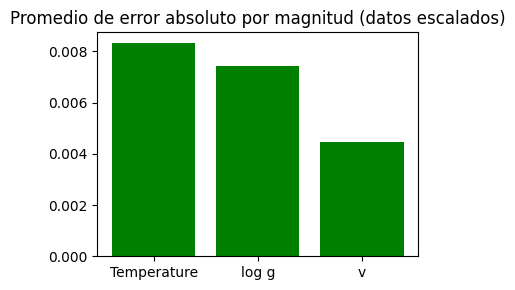

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(ensemble_prediction)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


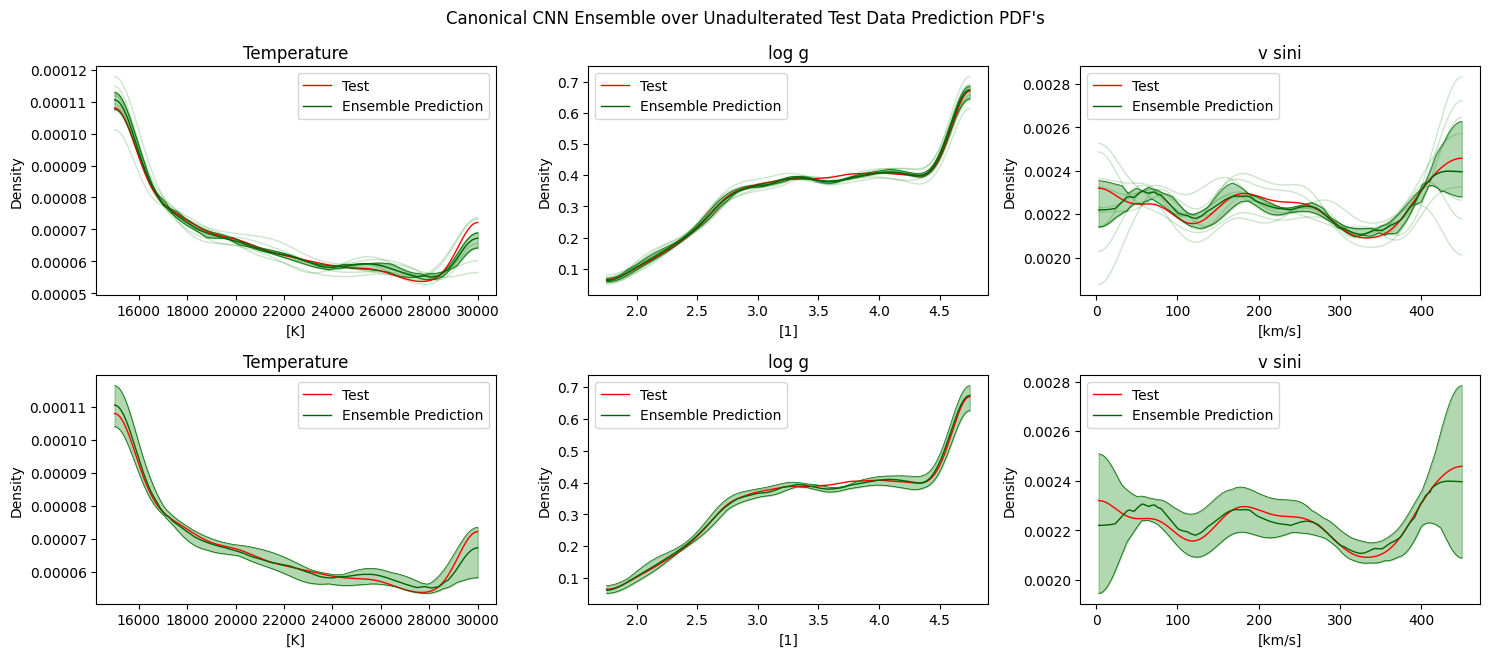

In [64]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Density')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Density')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])

plt.suptitle('Canonical CNN Ensemble over Unadulterated Test Data Prediction PDF\'s')
plt.tight_layout()
plt.show()

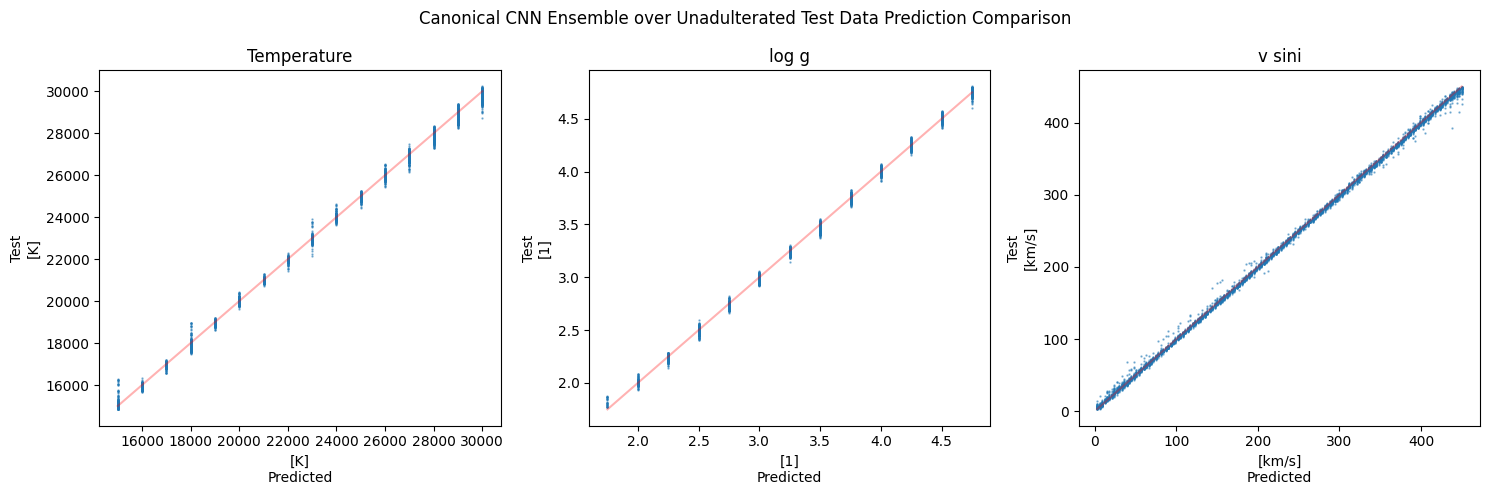

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Canonical CNN Ensemble over Unadulterated Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

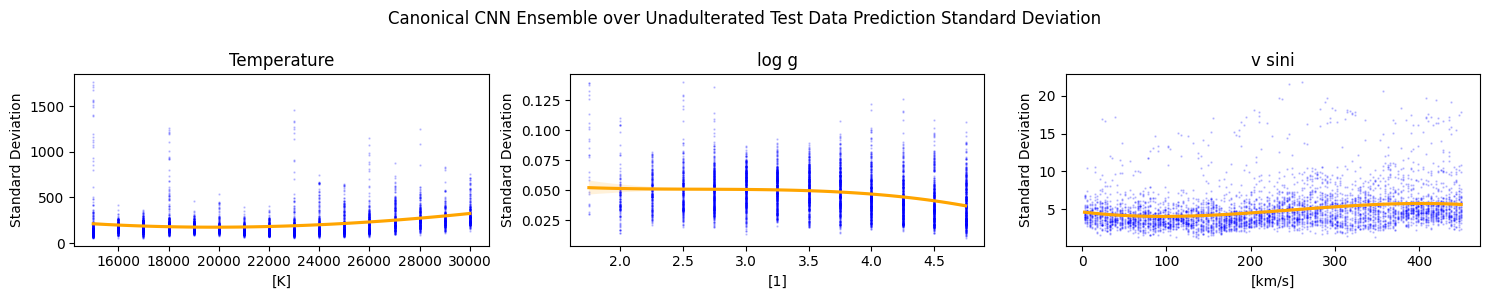

In [66]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temperatura':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temperatura', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Standard Deviation")
	axes[i].set_title(measure[i])
	#axes[i].legend()

plt.suptitle('Canonical CNN Ensemble over Unadulterated Test Data Prediction Standard Deviation')
plt.tight_layout()
plt.show()

In [67]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(ensemble_prediction-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(ensemble_prediction-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [68]:
# dataframe comparativo de datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
                    })
results.head(20)

,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,16927 ± 202,73.0 (0.4%),3.25,3.27 ± 0.04,0.02 (0.5%),246,247 ± 5,1.0 (0.5%)
1,18000,17923 ± 232,77.0 (0.4%),2.75,2.72 ± 0.06,0.03 (1.1%),285,287 ± 3,2.0 (0.8%)
2,30000,30104 ± 329,104.0 (0.3%),3.75,3.73 ± 0.05,0.02 (0.5%),267,264 ± 7,3.0 (1.1%)
3,23000,22152 ± 490,848.0 (3.7%),2.5,2.41 ± 0.06,0.09 (3.7%),63,66 ± 7,3.0 (5.4%)
4,19000,18892 ± 129,108.0 (0.6%),3.0,2.96 ± 0.07,0.04 (1.4%),126,125 ± 4,1.0 (0.6%)
5,17000,16891 ± 120,109.0 (0.6%),4.5,4.55 ± 0.03,0.05 (1.1%),156,152 ± 5,4.0 (2.8%)
6,28000,27858 ± 253,142.0 (0.5%),3.25,3.29 ± 0.05,0.04 (1.1%),450,446 ± 4,4.0 (0.9%)
7,22000,22007 ± 105,7.0 (0.0%),4.0,4.0 ± 0.03,0.0 (0.0%),285,286 ± 5,1.0 (0.2%)
8,23000,22948 ± 259,52.0 (0.2%),3.0,2.95 ± 0.07,0.05 (1.5%),30,32 ± 3,2.0 (6.3%)
9,23000,23118 ± 172,118.0 (0.5%),4.5,4.5 ± 0.04,0.0 (0.1%),153,150 ± 5,3.0 (1.9%)


# Espectro Observado

In [69]:
predictions = np.array([y_scaler.inverse_transform(model.predict(x_obs)) for model in models])

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)

8/8 [==============================] - 0s 4ms/step


In [70]:
# metricas por parametro
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(y_scaler.transform(ensemble_prediction)[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 22.097  MAE:3.584
log g -       loss: 19.991  MAE:3.290
v -           loss: 0.882  MAE:0.815


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

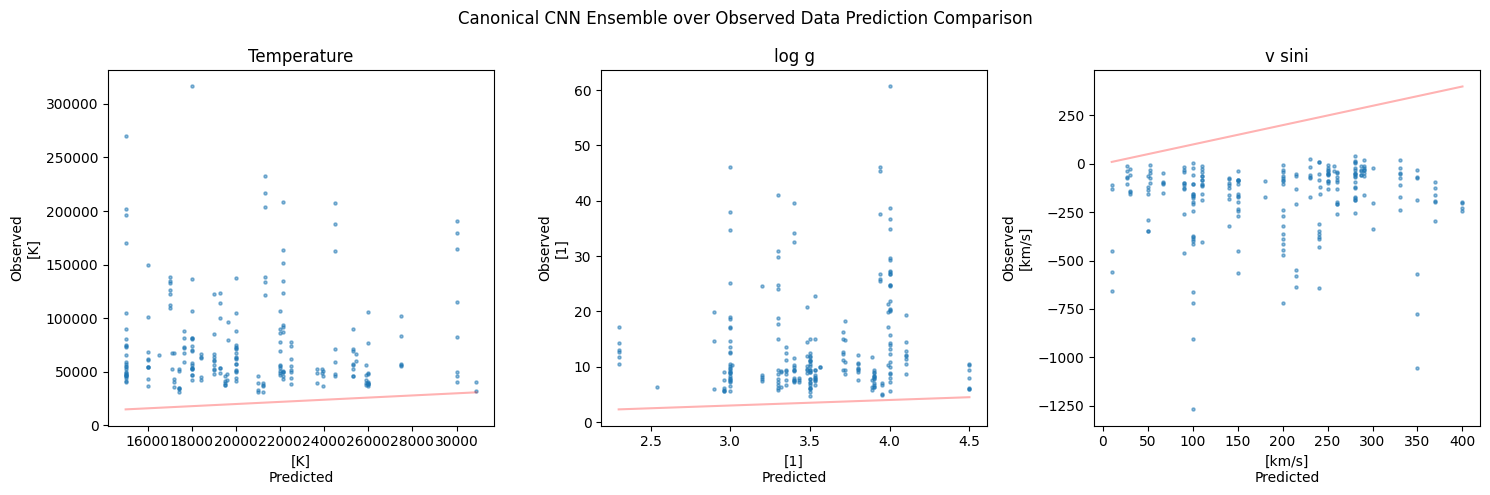

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=ensemble_prediction[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Canonical CNN Ensemble over Observed Data Prediction Comparison')
plt.tight_layout();
plt.show()

In [72]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [73]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
102776,2014-01-30,05-09-05,20000,49454 ± 6705,29454.0 (147.3%),3.2,8.16 ± 2.69,4.96 (154.9%),200,-87 ± 112,287.0 (143.3%),2033.455800
102776,2014-03-19,07-07-14,20000,137471 ± 31638,117471.0 (587.4%),3.2,24.6 ± 11.15,21.4 (668.8%),200,-472 ± 430,672.0 (336.0%),46271.848596
102776,2015-02-27,07-12-10,20000,51617 ± 8704,31617.0 (158.1%),3.2,8.55 ± 3.31,5.35 (167.3%),200,-74 ± 91,274.0 (136.9%),2572.922051
102776,2015-05-06,02-32-51,20000,41263 ± 5567,21263.0 (106.3%),3.2,7.4 ± 2.87,4.2 (131.4%),200,-7 ± 83,207.0 (103.7%),1684.305358
102776,2015-05-06,02-43-49,20000,44697 ± 6108,24697.0 (123.5%),3.2,7.71 ± 2.85,4.51 (141.0%),200,-31 ± 88,231.0 (115.5%),2205.749237
105382,2014-01-30,05-42-57,15000,58932 ± 10140,43932.0 (292.9%),3.4,10.04 ± 4.02,6.64 (195.3%),68,-153 ± 159,220.0 (326.1%),5619.844995
105382,2015-02-26,08-22-40,15000,44223 ± 8472,29223.0 (194.8%),3.4,7.27 ± 3.05,3.87 (113.7%),68,-49 ± 75,117.0 (172.9%),2160.609769
105382,2015-02-26,08-43-24,15000,52443 ± 9202,37443.0 (249.6%),3.4,9.4 ± 4.28,6.0 (176.6%),68,-98 ± 113,165.0 (244.7%),3824.823486
105382,2015-05-07,00-20-44,15000,55152 ± 8355,40152.0 (267.7%),3.4,9.19 ± 3.36,5.79 (170.4%),68,-104 ± 143,172.0 (254.5%),3827.770663
